# Big Mart Sales Prediction

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import OrdinalEncoder
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import mean_absolute_error 
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor, XGBRFRegressor
import joblib

## Dataset Importing & Analysis

In [2]:
#loading the dataset into a pandas Dataframe

data = pd.read_csv("train.csv")

In [3]:
# Display first 5 rows of the dataset

data.head()

,Item_Identifier,Item_Weight,Item_Fat_Content,Item_Visibility,Item_Type,Item_MRP,Outlet_Identifier,Outlet_Establishment_Year,Outlet_Size,Outlet_Location_Type,Outlet_Type,Item_Outlet_Sales
0,FDA15,9.30,Low Fat,0.016047,Dairy,249.8092,OUT049,1999,Medium,Tier 1,Supermarket Type1,3735.1380
1,DRC01,5.92,Regular,0.019278,Soft Drinks,48.2692,OUT018,2009,Medium,Tier 3,Supermarket Type2,443.4228
2,FDN15,17.50,Low Fat,0.016760,Meat,141.6180,OUT049,1999,Medium,Tier 1,Supermarket Type1,2097.2700
3,FDX07,19.20,Regular,0.000000,Fruits and Vegetables,182.0950,OUT010,1998,NaN,Tier 3,Grocery Store,732.3800
4,NCD19,8.93,Low Fat,0.000000,Household,53.8614,OUT013,1987,High,Tier 3,Supermarket Type1,994.7052


In [4]:
# no of rows and columns

data.shape

(8523, 12)

In [5]:
# information about the dataset

data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8523 entries, 0 to 8522
Data columns (total 12 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Item_Identifier            8523 non-null   object 
 1   Item_Weight                7060 non-null   float64
 2   Item_Fat_Content           8523 non-null   object 
 3   Item_Visibility            8523 non-null   float64
 4   Item_Type                  8523 non-null   object 
 5   Item_MRP                   8523 non-null   float64
 6   Outlet_Identifier          8523 non-null   object 
 7   Outlet_Establishment_Year  8523 non-null   int64  
 8   Outlet_Size                6113 non-null   object 
 9   Outlet_Location_Type       8523 non-null   object 
 10  Outlet_Type                8523 non-null   object 
 11  Item_Outlet_Sales          8523 non-null   float64
dtypes: float64(4), int64(1), object(7)
memory usage: 799.2+ KB


In [6]:
# finding missing values

data.isnull().sum()

Item_Identifier                 0
Item_Weight                  1463
Item_Fat_Content                0
Item_Visibility                 0
Item_Type                       0
Item_MRP                        0
Outlet_Identifier               0
Outlet_Establishment_Year       0
Outlet_Size                  2410
Outlet_Location_Type            0
Outlet_Type                     0
Item_Outlet_Sales               0
dtype: int64

In [7]:
# overall statistics of the data

data.describe()

,Item_Weight,Item_Visibility,Item_MRP,Outlet_Establishment_Year,Item_Outlet_Sales
count,7060.000000,8523.000000,8523.000000,8523.000000,8523.000000
mean,12.857645,0.066132,140.992782,1997.831867,2181.288914
std,4.643456,0.051598,62.275067,8.371760,1706.499616
min,4.555000,0.000000,31.290000,1985.000000,33.290000
25%,8.773750,0.026989,93.826500,1987.000000,834.247400
50%,12.600000,0.053931,143.012800,1999.000000,1794.331000
75%,16.850000,0.094585,185.643700,2004.000000,3101.296400
max,21.350000,0.328391,266.888400,2009.000000,13086.964800


## Data Cleaning

### Handling the Missing values

#### 'Item_Weight' Column

In [8]:
# finding the mean of the column 'Item_Weight'
data['Item_Weight'].mean()

12.857645184136183

In [9]:
# replacing the null values of 'Item_Weight' with the mean value of that column 

data['Item_Weight'].fillna(data['Item_Weight'].mean(), inplace = True)
data.isnull().sum()

Item_Identifier                 0
Item_Weight                     0
Item_Fat_Content                0
Item_Visibility                 0
Item_Type                       0
Item_MRP                        0
Outlet_Identifier               0
Outlet_Establishment_Year       0
Outlet_Size                  2410
Outlet_Location_Type            0
Outlet_Type                     0
Item_Outlet_Sales               0
dtype: int64

#### 'Outlet_Size' Column

In [10]:
# finding the num of null values in 'Outlet_Size'

data['Outlet_Size'].isnull().sum()

2410

In [11]:
# discovering the mode of 'Outlet_Size' with respect to 'Outlet_Type'

mode_of_outlet_size=data.pivot_table(values='Outlet_Size', columns = 'Outlet_Type', aggfunc=(lambda x: x.mode()[0]))

mode_of_outlet_size

Outlet_Type,Grocery Store,Supermarket Type1,Supermarket Type2,Supermarket Type3
Outlet_Size,Small,Small,Medium,Medium


In [12]:
missing_values = data['Outlet_Size'].isnull()
missing_values

0       False
1       False
2       False
3        True
4       False
        ...  
8518    False
8519     True
8520    False
8521    False
8522    False
Name: Outlet_Size, Length: 8523, dtype: bool

In [13]:
# replacing the missing values in "Outlet_Size" with mode

data.loc[missing_values, 'Outlet_Size'] = data.loc[missing_values, 'Outlet_Type'].apply(lambda x: mode_of_outlet_size[x])

data.isnull().sum()

Item_Identifier              0
Item_Weight                  0
Item_Fat_Content             0
Item_Visibility              0
Item_Type                    0
Item_MRP                     0
Outlet_Identifier            0
Outlet_Establishment_Year    0
Outlet_Size                  0
Outlet_Location_Type         0
Outlet_Type                  0
Item_Outlet_Sales            0
dtype: int64

### Data Transformation

#### 'Item_Fat_Content' column

In [14]:
# printing total count for each values in 'Item_Fat_Content'

data['Item_Fat_Content'].value_counts()

Low Fat    5089
Regular    2889
LF          316
reg         117
low fat     112
Name: Item_Fat_Content, dtype: int64

In [15]:
# converting the 'low fat' & 'LF' variable to 'Low Fat' and 'reg' to 'Regular'

data.replace({'Item_Fat_Content' : {'low fat' : 'Low Fat', 'LF' : 'Low Fat', 'reg' : 'Regular'}}, inplace = True)

In [16]:
data['Item_Fat_Content'].value_counts()

Low Fat    5517
Regular    3006
Name: Item_Fat_Content, dtype: int64

#### 'Item_Visibility' column

In [17]:
data['Item_Visibility'].value_counts()

0.000000    526
0.076975      3
0.162462      2
0.076841      2
0.073562      2
           ... 
0.013957      1
0.110460      1
0.124646      1
0.054142      1
0.044878      1
Name: Item_Visibility, Length: 7880, dtype: int64

In [18]:
# creating a new feature named 'Item_Visibility_Interpolate' and replacing the 0's with Interpolate values

data['Item_Visibility_Interpolate'] = data['Item_Visibility'].replace(0, np.nan).interpolate(method='linear')

In [19]:
data.head(1)

,Item_Identifier,Item_Weight,Item_Fat_Content,Item_Visibility,Item_Type,Item_MRP,Outlet_Identifier,Outlet_Establishment_Year,Outlet_Size,Outlet_Location_Type,Outlet_Type,Item_Outlet_Sales,Item_Visibility_Interpolate
0,FDA15,9.3,Low Fat,0.016047,Dairy,249.8092,OUT049,1999,Medium,Tier 1,Supermarket Type1,3735.138,0.016047


In [20]:
data['Item_Visibility_Interpolate'].value_counts()

0.076975    3
0.044024    2
0.040912    2
0.076856    2
0.078759    2
           ..
0.021011    1
0.099189    1
0.076866    1
0.014116    1
0.044878    1
Name: Item_Visibility_Interpolate, Length: 8405, dtype: int64

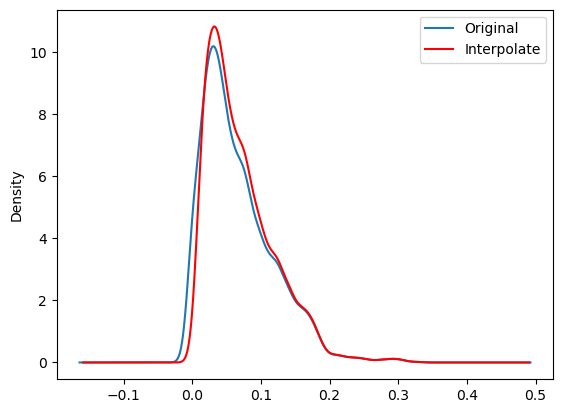

In [21]:
# visualizing both the original and updated column

data['Item_Visibility'].plot(kind='kde',label = 'Original')

data['Item_Visibility_Interpolate'].plot(kind='kde',color = 'red', label = 'Interpolate')

plt.legend()
plt.show()


In [22]:
# dropping the 'Item_Visibility' column

data = data.drop('Item_Visibility', axis = 1)

In [23]:
data.head(1)

,Item_Identifier,Item_Weight,Item_Fat_Content,Item_Type,Item_MRP,Outlet_Identifier,Outlet_Establishment_Year,Outlet_Size,Outlet_Location_Type,Outlet_Type,Item_Outlet_Sales,Item_Visibility_Interpolate
0,FDA15,9.3,Low Fat,Dairy,249.8092,OUT049,1999,Medium,Tier 1,Supermarket Type1,3735.138,0.016047


#### 'Item_Identifier' column

In [24]:
data['Item_Identifier'].value_counts()

FDW13    10
FDG33    10
NCY18     9
FDD38     9
DRE49     9
         ..
FDY43     1
FDQ60     1
FDO33     1
DRF48     1
FDC23     1
Name: Item_Identifier, Length: 1559, dtype: int64

In [25]:
# changing the values into their first two characters

data['Item_Identifier'] = data['Item_Identifier'].apply(lambda x: x[:2]) 

In [26]:
data['Item_Identifier'].value_counts()

FD    6125
NC    1599
DR     799
Name: Item_Identifier, dtype: int64

## Data VIsualization

### Numerical Features

In [27]:
sns.set()

<Figure size 600x600 with 0 Axes>

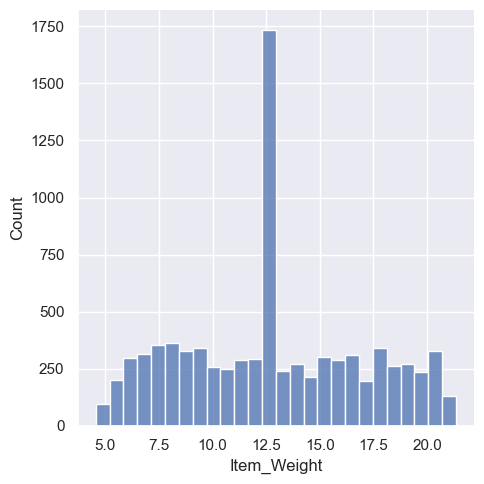

In [28]:
# Item_Weight distribution

plt.figure(figsize = [6,6])
sns.displot(data['Item_Weight'])
plt.show()

<Figure size 600x600 with 0 Axes>

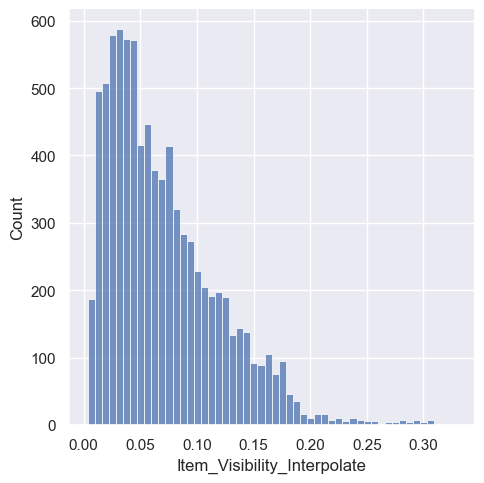

In [29]:
# Item_visibility distribution

plt.figure(figsize = [6,6])
sns.displot(data['Item_Visibility_Interpolate'])
plt.show()

<Figure size 600x600 with 0 Axes>

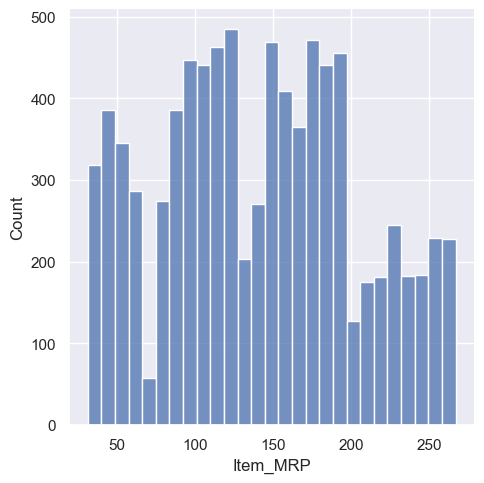

In [30]:
# Item_MRP distribution

plt.figure(figsize = [6,6])
sns.displot(data['Item_MRP'])
plt.show()

<Figure size 600x600 with 0 Axes>

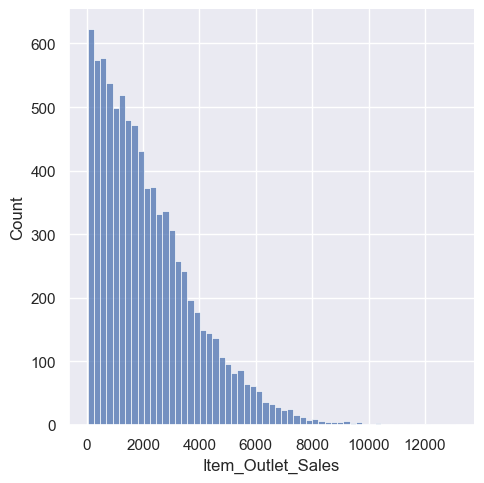

In [31]:
# Item_Outlet_Sales distribution

plt.figure(figsize = [6,6])
sns.displot(data['Item_Outlet_Sales'])
plt.show()

<function matplotlib.pyplot.show(close=None, block=None)>

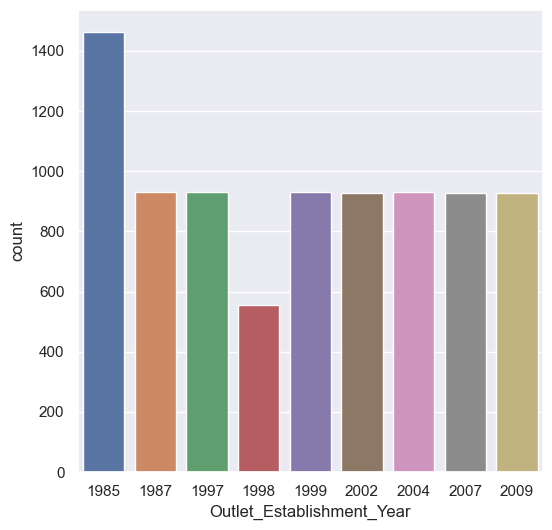

In [32]:
# Outlet_Establishment_Year column

plt.figure(figsize=[6,6])
sns.countplot(x='Outlet_Establishment_Year', data = data)
plt.show

### Categorical Features

<function matplotlib.pyplot.show(close=None, block=None)>

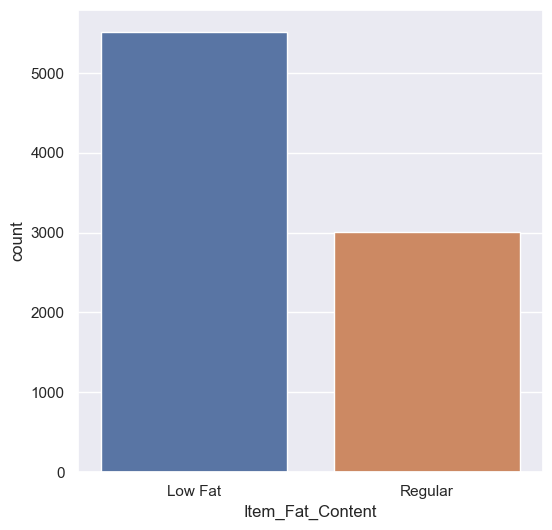

In [33]:
# Item_Fat_Content column

plt.figure(figsize=[6,6])
sns.countplot(x='Item_Fat_Content', data = data)
plt.show

<function matplotlib.pyplot.show(close=None, block=None)>

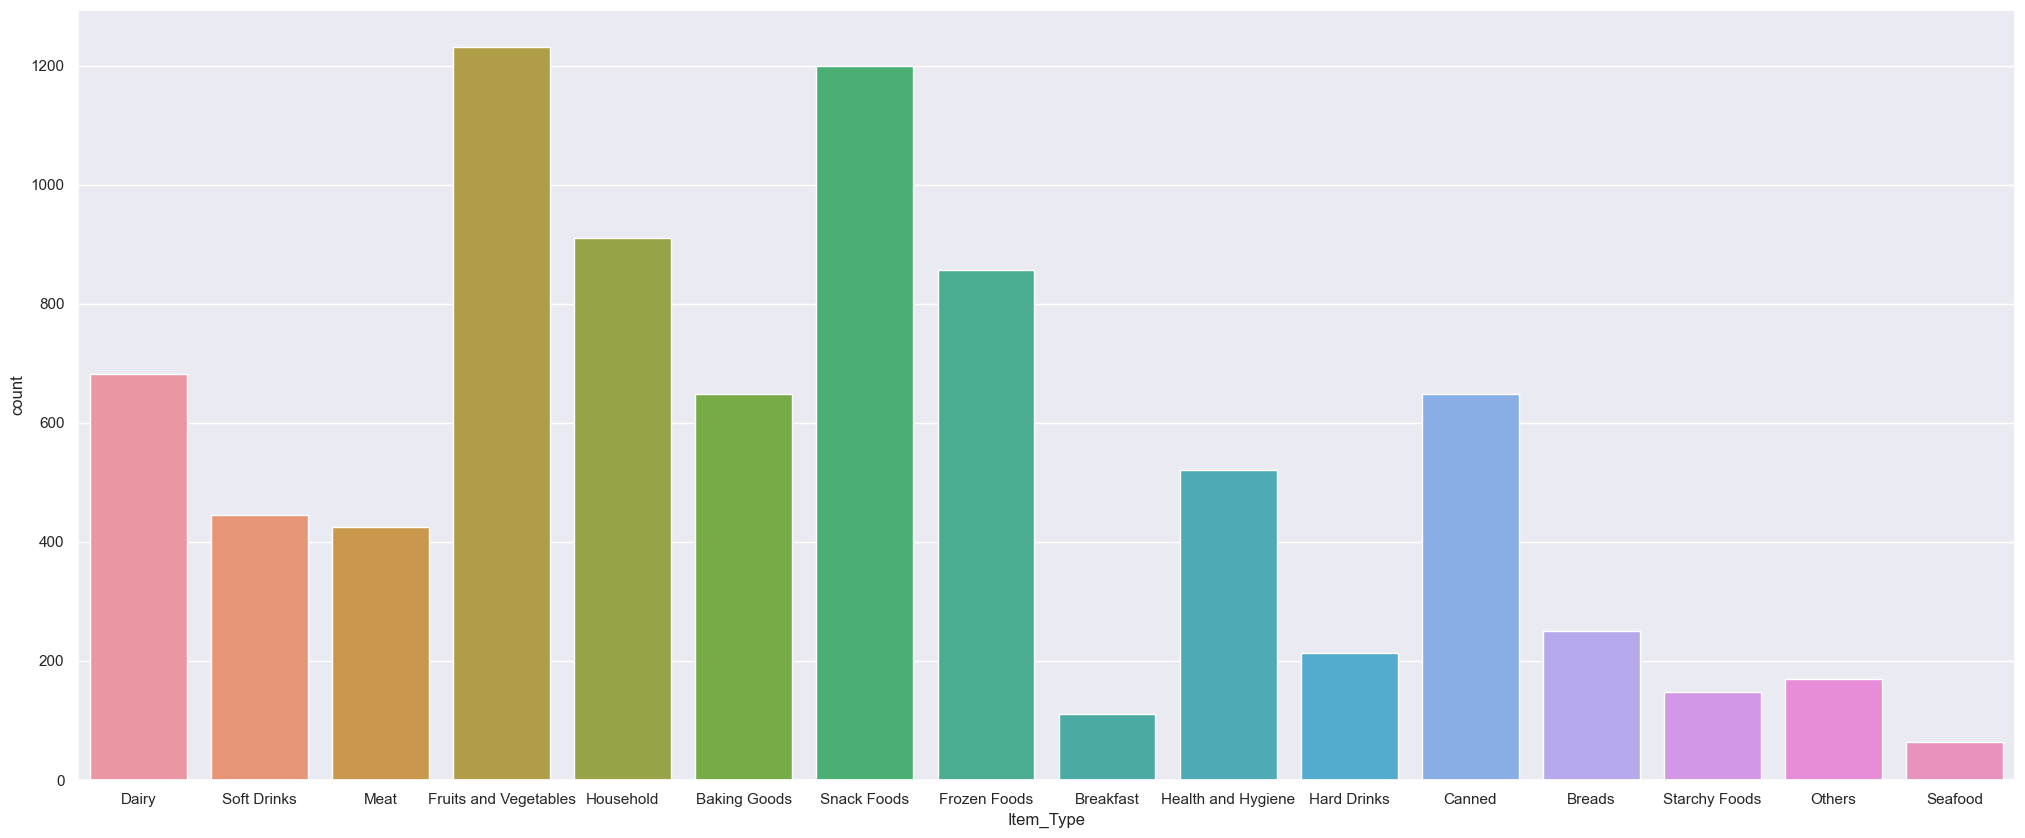

In [34]:
# Item_Type column

plt.figure(figsize=[25,10])
sns.countplot(x='Item_Type', data = data)
plt.show

<function matplotlib.pyplot.show(close=None, block=None)>

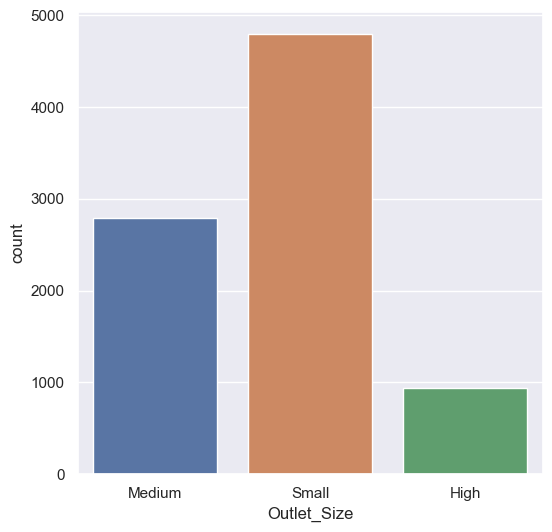

In [35]:
# Outlet_Size column

plt.figure(figsize=[6,6])
sns.countplot(x='Outlet_Size', data = data)
plt.show

<function matplotlib.pyplot.show(close=None, block=None)>

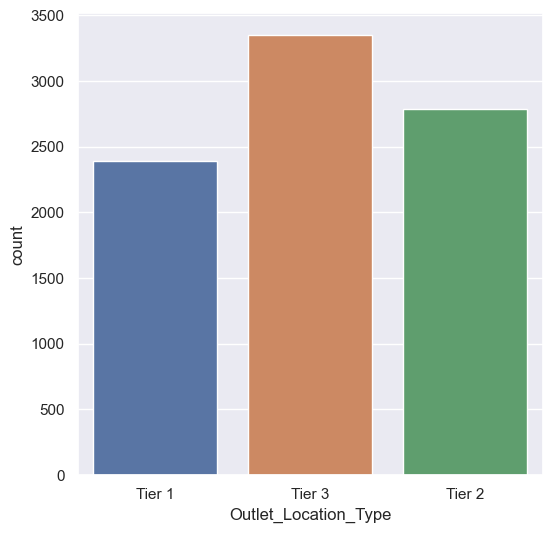

In [36]:
# Outlet_Location_Type column

plt.figure(figsize=[6,6])
sns.countplot(x='Outlet_Location_Type', data = data)
plt.show

<function matplotlib.pyplot.show(close=None, block=None)>

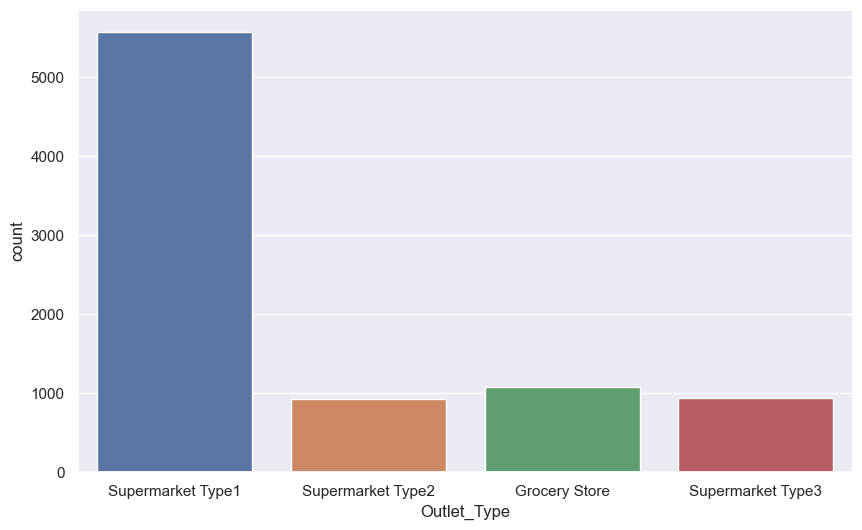

In [37]:
# Outlet_Type column

plt.figure(figsize=[10,6])
sns.countplot(x='Outlet_Type', data = data)
plt.show

## Categorical Data Encoding

In [38]:
# encoding the categorical varables using OrdinalEncoder

data_encoded = data.copy()

cat_cols = data.select_dtypes(include=['object']).columns

for col in cat_cols:
    oe = OrdinalEncoder()
    data_encoded[col] = oe.fit_transform(data_encoded[[col]])
    print(oe.categories_)

[array(['DR', 'FD', 'NC'], dtype=object)]
[array(['Low Fat', 'Regular'], dtype=object)]
[array(['Baking Goods', 'Breads', 'Breakfast', 'Canned', 'Dairy',
       'Frozen Foods', 'Fruits and Vegetables', 'Hard Drinks',
       'Health and Hygiene', 'Household', 'Meat', 'Others', 'Seafood',
       'Snack Foods', 'Soft Drinks', 'Starchy Foods'], dtype=object)]
[array(['OUT010', 'OUT013', 'OUT017', 'OUT018', 'OUT019', 'OUT027',
       'OUT035', 'OUT045', 'OUT046', 'OUT049'], dtype=object)]
[array(['High', 'Medium', 'Small'], dtype=object)]
[array(['Tier 1', 'Tier 2', 'Tier 3'], dtype=object)]
[array(['Grocery Store', 'Supermarket Type1', 'Supermarket Type2',
       'Supermarket Type3'], dtype=object)]


In [39]:
# splitting the dataset into independent and dependent data

X = data_encoded.drop('Item_Outlet_Sales', axis = 1)
y = data_encoded['Item_Outlet_Sales']

In [40]:
y

0       3735.1380
1        443.4228
2       2097.2700
3        732.3800
4        994.7052
          ...    
8518    2778.3834
8519     549.2850
8520    1193.1136
8521    1845.5976
8522     765.6700
Name: Item_Outlet_Sales, Length: 8523, dtype: float64

## Data Processing

### Random Forest Regressor

In [41]:
# finding the R-Squared score of Random Forest Regresor

rf = RandomForestRegressor(n_estimators = 100, random_state = 42)
scores = cross_val_score(rf,X,y,cv = 5, scoring = 'r2' )
print(scores.mean())

0.5518327087520445


### XGBRegressor

In [42]:
# finding the R-Squared score of XGBRegressor


xgb = XGBRegressor(random_state = 42)
scores = cross_val_score(xgb,X,y,cv = 5, scoring = 'r2')
print(scores.mean())

0.5110386779677314


### XGBRF Regressor

In [43]:
# finding the R-Squared score of XGBRF Regressor


xg = XGBRFRegressor(n_estimators=100,random_state=42)
scores = cross_val_score(xg,X,y,cv = 5,scoring='r2')
print(scores.mean())

0.5954555125192931


## Model Fitting

In [44]:
# fitting the X & y into XGBRF Regressor

xg.fit(X,y)

XGBRFRegressor(base_score=None, booster=None, callbacks=None,
               colsample_bylevel=None, colsample_bytree=None, device=None,
               early_stopping_rounds=None, enable_categorical=False,
               eval_metric=None, feature_types=None, gamma=None,
               grow_policy=None, importance_type=None,
               interaction_constraints=None, max_bin=None,
               max_cat_threshold=None, max_cat_to_onehot=None,
               max_delta_step=None, max_depth=None, max_leaves=None,
               min_child_weight=None, missing=nan, monotone_constraints=None,
               multi_strategy=None, n_estimators=100, n_jobs=None,
               num_parallel_tree=None, objective='reg:squarederror',
               random_state=42, reg_alpha=None, ...)

In [45]:
# splitting into test and train data with test size as 20%

X_train,X_test,y_train,y_test = train_test_split(X,y,test_size = 0.20,random_state=42)

In [46]:
# fitting the training data

xg.fit(X_train,y_train)

XGBRFRegressor(base_score=None, booster=None, callbacks=None,
               colsample_bylevel=None, colsample_bytree=None, device=None,
               early_stopping_rounds=None, enable_categorical=False,
               eval_metric=None, feature_types=None, gamma=None,
               grow_policy=None, importance_type=None,
               interaction_constraints=None, max_bin=None,
               max_cat_threshold=None, max_cat_to_onehot=None,
               max_delta_step=None, max_depth=None, max_leaves=None,
               min_child_weight=None, missing=nan, monotone_constraints=None,
               multi_strategy=None, n_estimators=100, n_jobs=None,
               num_parallel_tree=None, objective='reg:squarederror',
               random_state=42, reg_alpha=None, ...)

In [47]:
# assigning the prediction variable

y_pred = xg.predict(X_test)

In [48]:
# finding MAE of the model

mean_absolute_error(y_test,y_pred)

712.3854642800358

## Data Prediction

### Predicting the sales amount

In [49]:
# running the prediction with random values

pred = xg.predict(np.array([[1.0,9.30,0.0,4.0,249.8092,9.0,1999,1.0,0.0,1.0,0.016047]]))[0]
pred

4043.5344

In [50]:
# printing the error adjusted predicted value

print(f"Sales value is between {pred-712.38} and {pred+712.38}")

Sales value is between 3331.154423828125 and 4755.914423828125


## Saving the Model

In [51]:
# saving the model using joblib

joblib.dump(xg,'Bigmart Sales Prediction')

['Bigmart Sales Prediction']

In [52]:
# assigning the model to the variable

model = joblib.load('Bigmart Sales Prediction')

In [53]:
# running prediction

pred = model.predict(np.array([[0.0,5.92,1.0,14.0,48.2692,3.0,2009,1.0,2.0,2.0,0.019278]]))[0]
pred

715.17957

In [54]:
# error adjusted prediction result

print(f"Sales value is between {pred-712.38} and {pred+712.38}")

Sales value is between 2.7995654296875045 and 1427.5595654296876
